Extract aggregated data for biological groups for MPRI spill scenarios

In [1]:
import os
import xarray as xr
import numpy as np
import pandas as pd
import itertools
from pathlib import Path
import geopandas as gpd
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import ssam_groups as groups
import ssam_plot as splot
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
affected_boxes = {'TP': [1, 2, 3, 4, 5, 8, 9, 33, 34, 37, 60, 66],'AP': [33, 60, 63], 'EB': [72, 74, 75, 80], 'JF': [1, 2]}

### Define scenario and control files

In [3]:
control_root = Path('/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/Control/')
control_paths = sorted([p for p in control_root.glob('highres-control-3y-*/outputSalishSea.nc')])
for path in control_paths:
    print(path.parent.stem)

highres-control-3y-2019-2022
highres-control-3y-2029-2032
highres-control-3y-2039-2042


In [5]:
control_datasets = [xr.open_dataset(ctr,decode_cf=True) for ctr in control_paths]
#time = np.ma.filled(control.variables['t'])

In [8]:
control_datasets[0]

<xarray.Dataset>
Dimensions:                            (t: 366, b: 130, z: 7)
Coordinates:
  * t                                  (t) datetime64[ns] 2018-12-24T14:00:00...
Dimensions without coordinates: b, z
Data variables: (12/1010)
    volume                             (t, b, z) float64 ...
    hdsource                           (t, b, z) float64 ...
    hdsink                             (t, b, z) float64 ...
    eflux                              (t, b, z) float64 ...
    vflux                              (t, b, z) float64 ...
    porosity                           (t, b, z) float64 ...
    ...                                 ...
    Filter_feeder_Prop_Benzo           (t, b) float64 ...
    Sponges_Prop_Benzo                 (t, b) float64 ...
    Benthic_grazer_Prop_Benzo          (t, b) float64 ...
    Macrobenthos_Prop_Benzo            (t, b) float64 ...
    Macroalgae_Prop_Benzo              (t, b) float64 ...
    Seagrass_Prop_Benzo                (t, b) float64 ...
Attributes:
    title:       SalishSea
    geometry:    SS_xy.bgm
    parameters:  ./atlantisMerged -i init_conditions.nc 0 -o outputSalishSea....
    wcnz:        6
    sednz:       1

In [9]:
control_datasets[1]

<xarray.Dataset>
Dimensions:                            (t: 366, b: 130, z: 7)
Coordinates:
  * t                                  (t) datetime64[ns] 2028-12-21T14:00:00...
Dimensions without coordinates: b, z
Data variables: (12/1010)
    volume                             (t, b, z) float64 ...
    hdsource                           (t, b, z) float64 ...
    hdsink                             (t, b, z) float64 ...
    eflux                              (t, b, z) float64 ...
    vflux                              (t, b, z) float64 ...
    porosity                           (t, b, z) float64 ...
    ...                                 ...
    Filter_feeder_Prop_Benzo           (t, b) float64 ...
    Sponges_Prop_Benzo                 (t, b) float64 ...
    Benthic_grazer_Prop_Benzo          (t, b) float64 ...
    Macrobenthos_Prop_Benzo            (t, b) float64 ...
    Macroalgae_Prop_Benzo              (t, b) float64 ...
    Seagrass_Prop_Benzo                (t, b) float64 ...
Attributes:
    title:       SalishSea
    geometry:    SS_xy.bgm
    parameters:  ./atlantisMerged -i init_conditions.nc 0 -o outputSalishSea....
    wcnz:        6
    sednz:       1

In [10]:
scenario_root = Path('/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/MPRI1/')
scenario_paths = sorted([p for p in scenario_root.glob('highres-*/outputSalishSea.nc')])
for path in scenario_paths:
    print(path.parent.stem, groups.conditions[str(path.parent.stem).split(sep = '_')[3]])

highres-2019-2022_4a_1_2019-07-04 low Fraser flow spring tide summer
highres-2019-2022_4a_2_2019-07-10 low Fraser flow neap tide summer
highres-2019-2022_4a_3_2020-07-22 high Fraser flow spring tide summer
highres-2019-2022_4a_4_2020-07-12 high Fraser flow neap tide summer
highres-2019-2022_5b_1_2019-01-20 low Fraser flow spring tide winter
highres-2019-2022_5b_2_2019-01-14 low Fraser flow neap tide winter
highres-2019-2022_5b_3_2020-01-24 high Fraser flow spring tide winter
highres-2019-2022_5b_4_2020-01-16 high Fraser flow neap tide winter
highres-2019-2022_6a_1_2019-07-16 low Fraser flow spring tide summer
highres-2019-2022_6a_2_2019-07-25 low Fraser flow neap tide summer
highres-2019-2022_6a_3_2020-07-21 high Fraser flow spring tide summer
highres-2019-2022_6a_4_2020-07-13 high Fraser flow neap tide summer
highres-2019-2022_7a_1_2019-01-21 low Fraser flow spring tide winter
highres-2019-2022_7a_2_2019-01-26 low Fraser flow neap tide winter
highres-2019-2022_7a_3_2020-01-11 high Fra

In [11]:
scenario_datasets = [xr.open_dataset(scen,decode_cf=True) for scen in scenario_paths]

In [13]:
plankton = {
    'microzooplankton':'MicroZoo', 'carnivorous zooplankton':'Carniv_Zoo', 'gelatinous zooplantkon':'Gelat_Zoo', 
    'mesozooplankton':'Zoo', 'diatoms':'Diatom', 'picophytoplankton':'PicoPhytopl', 'pelagic bacteria':'Pelag_Bact',
    'squid':'Squid',
}

pelagic_fish = {
    'small pelagic':'Small_pelagic_fish', 
    'hake':'Hake','lingcod':'Lingcod', 'pollock':'Pollock', 
    'rockfish':'Rockfish', 'pacific herring':'Pacific_herring',
}

demersal_fish = {
    'benthopelagic':'Benthopelagic', 'small demersal':'Small_Demersal_fish', 
    'large demersal':'Large_Demersal_fish', 'small flatfish':'Small_Flatfish', 'large flatfish':'Large_Flatfish',
    'sandlance':'Sandlance',
}

cetaceans = {
    'humpbacks':'Humpback_whales', 'porpoises':'Harbor_porpoise', 
    'resident orcas':'Orcas_resident', 'transient orcas':'Orcas_transient',
}

pinnipeds = {
    'seals':'Harbor_seals', 'sealions':'Sealions',
}

sensitivity = { 'benthic_invertebrates':0.5,'marine_plants':2, 'seabirds':1.2, 'cetaceans':0.4,'salmon':0.6,
    'demersal_fish'	:0.2,'pelagic_fish'	:0.3,'pinnipeds':0.1,'plankton':0.1,'elasmobranchs':0.1,
}

In [16]:
def aggregate_boxplot_data_pelagic(bio_group, bio_group_name, location=groups.salish_sea):
    all_results = []
    data_labels = ['spill year', '10 years later', '20 years later']

    for scenario, path in zip(scenario_datasets[0:16], scenario_paths[0:16]):
        control = control_datasets[0]
        nm = str(path.parent.stem).split(sep='_')
        year = str(nm[3])
        if nm[1] == '4a':
            scenario_name = 'AP-'+nm[2]
            hex_colour = '#863092'            
        elif nm[1] == '5b':
            scenario_name = 'TP-'+nm[2]
            hex_colour = '#6DB48E'
        elif nm[1] == '6a':
            scenario_name = 'EB-'+nm[2]
            hex_colour = '#2F61A4'
        elif nm[1] == '7a':
            scenario_name = 'JF-'+nm[2]
            hex_colour = '#A27170'

        p_oiled = 0
        p_control = 0
        for species in bio_group: 
            p_oiled = p_oiled + np.ma.filled(scenario.variables[bio_group[species] + '_N'][:, location, 0:6], np.nan)
            p_control = p_control + np.ma.filled(control.variables[bio_group[species] + '_N'][:, location, 0:6], np.nan)
        
            p_oiled = p_oiled.sum(axis=(1, 2)).mean()
            p_control = p_control.sum(axis=(1, 2)).mean()
            p_ratio = (p_oiled / p_control - 1) * 100
            
        all_results.append({
        'bio_group': bio_group_name,
        'time_label': 'spill year',
        'scenario': scenario_name,
        'percent_change': p_ratio,
        'sensitivity': sensitivity[bio_group_name],
        'sensitivity_negative': -sensitivity[bio_group_name],
    })

    for scenario, path in zip(scenario_datasets[16:32], scenario_paths[16:32]):
        control = control_datasets[1]
        nm = str(path.parent.stem).split(sep='_')
        year = str(nm[3])
        if nm[1] == '4a':
            scenario_name = 'AP-'+nm[2]
            hex_colour = '#863092'            
        elif nm[1] == '5b':
            scenario_name = 'TP-'+nm[2]
            hex_colour = '#6DB48E'
        elif nm[1] == '6a':
            scenario_name = 'EB-'+nm[2]
            hex_colour = '#2F61A4'
        elif nm[1] == '7a':
            scenario_name = 'JF-'+nm[2]
            hex_colour = '#A27170'

        p_oiled = 0
        p_control = 0
        for species in bio_group: 
            p_oiled = p_oiled + np.ma.filled(scenario.variables[bio_group[species] + '_N'][:, location, 0:6], np.nan)
            p_control = p_control + np.ma.filled(control.variables[bio_group[species] + '_N'][:, location, 0:6], np.nan)
        
            p_oiled = p_oiled.sum(axis=(1, 2)).mean()
            p_control = p_control.sum(axis=(1, 2)).mean()
            p_ratio = (p_oiled / p_control - 1) * 100
            
        all_results.append({
        'bio_group': bio_group_name,
        'time_label': '10 years later',
        'scenario': scenario_name,
        'percent_change': p_ratio,
        'sensitivity': sensitivity[bio_group_name],
        'sensitivity_negative': -sensitivity[bio_group_name],
    })

    for scenario, path in zip(scenario_datasets[32:len(scenario_datasets)+1], scenario_paths[32:len(scenario_datasets)+1]):
        control = control_datasets[2]
        nm = str(path.parent.stem).split(sep='_')
        year = str(nm[3])
        if nm[1] == '4a':
            scenario_name = 'AP-'+nm[2]
            hex_colour = '#863092'            
        elif nm[1] == '5b':
            scenario_name = 'TP-'+nm[2]
            hex_colour = '#6DB48E'
        elif nm[1] == '6a':
            scenario_name = 'EB-'+nm[2]
            hex_colour = '#2F61A4'
        elif nm[1] == '7a':
            scenario_name = 'JF-'+nm[2]
            hex_colour = '#A27170'

        p_oiled = 0
        p_control = 0
        for species in bio_group: 
            p_oiled = p_oiled + np.ma.filled(scenario.variables[bio_group[species] + '_N'][:, location, 0:6], np.nan)
            p_control = p_control + np.ma.filled(control.variables[bio_group[species] + '_N'][:, location, 0:6], np.nan)
        
            p_oiled = p_oiled.sum(axis=(1, 2)).mean()
            p_control = p_control.sum(axis=(1, 2)).mean()
            p_ratio = (p_oiled / p_control - 1) * 100
            
        all_results.append({
        'bio_group': bio_group_name,
        'time_label': '20 years later',
        'scenario': scenario_name,
        'percent_change': p_ratio,
        'sensitivity': sensitivity[bio_group_name],
        'sensitivity_negative': -sensitivity[bio_group_name],
    })

    df = pd.DataFrame(all_results)
    df.to_csv("/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/MPRI1/aggregated-data-"+bio_group_name+".csv")

In [18]:
def aggregate_boxplot_data_vertebrates(bio_group, bio_group_name, location=groups.salish_sea):
    all_results = []
    data_labels = ['spill year', '10 years later', '20 years later']

    for scenario, path in zip(scenario_datasets[0:16], scenario_paths[0:16]):
        control = control_datasets[0]
        nm = str(path.parent.stem).split(sep='_')
        year = str(nm[3])
        if nm[1] == '4a':
            scenario_name = 'AP-'+nm[2]
            hex_colour = '#863092'            
        elif nm[1] == '5b':
            scenario_name = 'TP-'+nm[2]
            hex_colour = '#6DB48E'
        elif nm[1] == '6a':
            scenario_name = 'EB-'+nm[2]
            hex_colour = '#2F61A4'
        elif nm[1] == '7a':
            scenario_name = 'JF-'+nm[2]
            hex_colour = '#A27170'
            
        aggregate_ratio = 0
        for species in bio_group:

            species_ratio = 0

            numCohorts = groups.cohorts[bio_group[species]]
            for cohort in range (1, numCohorts+1):
                new_species = bio_group[species] + str(cohort)
            
                o_numbers_tbl = np.ma.filled(scenario.variables[new_species + '_Nums'][:, location, 0:6], np.nan)
                o_structuralN_tbl = np.ma.filled(scenario.variables[new_species +'_StructN'][:, location, 0:6], np.nan)
                o_reservedN_tbl = np.ma.filled(scenario.variables[new_species +'_ResN'][:, location, 0:6], np.nan)

                c_numbers_tbl = np.ma.filled(control.variables[new_species + '_Nums'][:, location, 0:6], np.nan)
                c_structuralN_tbl = np.ma.filled(control.variables[new_species +'_StructN'][:, location, 0:6], np.nan)
                c_reservedN_tbl = np.ma.filled(control.variables[new_species +'_ResN'][:, location, 0:6], np.nan)

                o_weightatage_tbl = (o_structuralN_tbl + o_reservedN_tbl) * o_numbers_tbl 
                o_weightatage = o_weightatage_tbl.sum(axis=(1,2)).mean()

                c_weightatage_tbl = (c_structuralN_tbl + c_reservedN_tbl) * c_numbers_tbl 
                c_weightatage = c_weightatage_tbl.sum(axis=(1,2)).mean()

                cohort_ratio = (o_weightatage / c_weightatage - 1) * 100
                #print(scenario_name, species, cohort, cohort_ratio)
                species_ratio = species_ratio + cohort_ratio

            final_species_ratio = species_ratio/numCohorts
            #print(scenario_name, species, final_species_ratio)
            aggregate_ratio = aggregate_ratio + final_species_ratio
        
        value = aggregate_ratio/len(bio_group)
        #print(scenario_name, bio_group_name, aggregate_ratio, aggregate_ratio/len(bio_group)
        
        all_results.append({
        'bio_group': bio_group_name,
        'time_label': 'spill year',
        'scenario': scenario_name,
        'percent_change': value,
        'sensitivity': sensitivity[bio_group_name],
        'sensitivity_negative': -sensitivity[bio_group_name],
        })
    
    for scenario, path in zip(scenario_datasets[16:32], scenario_paths[16:32]):
        control = control_datasets[1]
        nm = str(path.parent.stem).split(sep='_')
        year = str(nm[3])
        if nm[1] == '4a':
            scenario_name = 'AP-'+nm[2]
            hex_colour = '#863092'            
        elif nm[1] == '5b':
            scenario_name = 'TP-'+nm[2]
            hex_colour = '#6DB48E'
        elif nm[1] == '6a':
            scenario_name = 'EB-'+nm[2]
            hex_colour = '#2F61A4'
        elif nm[1] == '7a':
            scenario_name = 'JF-'+nm[2]
            hex_colour = '#A27170'
            
        aggregate_ratio = 0
        for species in bio_group:

            species_ratio = 0

            numCohorts = groups.cohorts[bio_group[species]]
            for cohort in range (1, numCohorts+1):
                new_species = bio_group[species] + str(cohort)
            
                o_numbers_tbl = np.ma.filled(scenario.variables[new_species + '_Nums'][:, location, 0:6], np.nan)
                o_structuralN_tbl = np.ma.filled(scenario.variables[new_species +'_StructN'][:, location, 0:6], np.nan)
                o_reservedN_tbl = np.ma.filled(scenario.variables[new_species +'_ResN'][:, location, 0:6], np.nan)

                c_numbers_tbl = np.ma.filled(control.variables[new_species + '_Nums'][:, location, 0:6], np.nan)
                c_structuralN_tbl = np.ma.filled(control.variables[new_species +'_StructN'][:, location, 0:6], np.nan)
                c_reservedN_tbl = np.ma.filled(control.variables[new_species +'_ResN'][:, location, 0:6], np.nan)

                o_weightatage_tbl = (o_structuralN_tbl + o_reservedN_tbl) * o_numbers_tbl 
                o_weightatage = o_weightatage_tbl.sum(axis=(1,2)).mean()

                c_weightatage_tbl = (c_structuralN_tbl + c_reservedN_tbl) * c_numbers_tbl 
                c_weightatage = c_weightatage_tbl.sum(axis=(1,2)).mean()

                cohort_ratio = (o_weightatage / c_weightatage - 1) * 100
                #print(scenario_name, species, cohort, cohort_ratio)
                species_ratio = species_ratio + cohort_ratio

            final_species_ratio = species_ratio/numCohorts
            #print(scenario_name, species, final_species_ratio)
            aggregate_ratio = aggregate_ratio + final_species_ratio
        
        value = aggregate_ratio/len(bio_group)
        #print(scenario_name, bio_group_name, aggregate_ratio, aggregate_ratio/len(bio_group)
        
        all_results.append({
        'bio_group': bio_group_name,
        'time_label': '10 years later',
        'scenario': scenario_name,
        'percent_change': value,
        'sensitivity': sensitivity[bio_group_name],
        'sensitivity_negative': -sensitivity[bio_group_name],
        })

    for scenario, path in zip(scenario_datasets[32:len(scenario_datasets)+1], scenario_paths[32:len(scenario_datasets)+1]):
        control = control_datasets[2]
        nm = str(path.parent.stem).split(sep='_')
        year = str(nm[3])
        if nm[1] == '4a':
            scenario_name = 'AP-'+nm[2]
            hex_colour = '#863092'            
        elif nm[1] == '5b':
            scenario_name = 'TP-'+nm[2]
            hex_colour = '#6DB48E'
        elif nm[1] == '6a':
            scenario_name = 'EB-'+nm[2]
            hex_colour = '#2F61A4'
        elif nm[1] == '7a':
            scenario_name = 'JF-'+nm[2]
            hex_colour = '#A27170'
            
        aggregate_ratio = 0
        for species in bio_group:

            species_ratio = 0

            numCohorts = groups.cohorts[bio_group[species]]
            for cohort in range (1, numCohorts+1):
                new_species = bio_group[species] + str(cohort)
            
                o_numbers_tbl = np.ma.filled(scenario.variables[new_species + '_Nums'][:, location, 0:6], np.nan)
                o_structuralN_tbl = np.ma.filled(scenario.variables[new_species +'_StructN'][:, location, 0:6], np.nan)
                o_reservedN_tbl = np.ma.filled(scenario.variables[new_species +'_ResN'][:, location, 0:6], np.nan)

                c_numbers_tbl = np.ma.filled(control.variables[new_species + '_Nums'][:, location, 0:6], np.nan)
                c_structuralN_tbl = np.ma.filled(control.variables[new_species +'_StructN'][:, location, 0:6], np.nan)
                c_reservedN_tbl = np.ma.filled(control.variables[new_species +'_ResN'][:, location, 0:6], np.nan)

                o_weightatage_tbl = (o_structuralN_tbl + o_reservedN_tbl) * o_numbers_tbl 
                o_weightatage = o_weightatage_tbl.sum(axis=(1,2)).mean()

                c_weightatage_tbl = (c_structuralN_tbl + c_reservedN_tbl) * c_numbers_tbl 
                c_weightatage = c_weightatage_tbl.sum(axis=(1,2)).mean()

                cohort_ratio = (o_weightatage / c_weightatage - 1) * 100
                #print(scenario_name, species, cohort, cohort_ratio)
                species_ratio = species_ratio + cohort_ratio

            final_species_ratio = species_ratio/numCohorts
            #print(scenario_name, species, final_species_ratio)
            aggregate_ratio = aggregate_ratio + final_species_ratio
        
        value = aggregate_ratio/len(bio_group)
        #print(scenario_name, bio_group_name, aggregate_ratio, aggregate_ratio/len(bio_group)
        
        all_results.append({
        'bio_group': bio_group_name,
        'time_label': '20 years later',
        'scenario': scenario_name,
        'percent_change': value,
        'sensitivity': sensitivity[bio_group_name],
        'sensitivity_negative': -sensitivity[bio_group_name],
        })

    df = pd.DataFrame(all_results)
    df.to_csv("/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/MPRI1/aggregated-data-"+bio_group_name+".csv")

In [19]:
def aggregate_boxplot_data_benthic(bio_group, bio_group_name, location=groups.salish_sea):
    all_results = []
    data_labels = ['spill year', '10 years later', '20 years later']

    for scenario, path in zip(scenario_datasets[0:16], scenario_paths[0:16]):
        control = control_datasets[0]
        nm = str(path.parent.stem).split(sep='_')
        year = str(nm[3])
        if nm[1] == '4a':
            scenario_name = 'AP-'+nm[2]
            hex_colour = '#863092'           
        elif nm[1] == '5b':
            scenario_name = 'TP-'+nm[2]
            hex_colour = '#6DB48E'
        elif nm[1] == '6a':
            scenario_name = 'EB-'+nm[2]
            hex_colour = '#2F61A4'
        elif nm[1] == '7a':
            scenario_name = 'JF-'+nm[2]
            hex_colour = '#A27170'

        p_oiled = 0
        p_control = 0
        for species in bio_group: 
            p_oiled = p_oiled + np.ma.filled(scenario.variables[bio_group[species] + '_N'][:, location], np.nan)
            p_control = p_control + np.ma.filled(control.variables[bio_group[species] + '_N'][:, location], np.nan)
        
        p_oiled = p_oiled.sum(axis=1).mean()
        p_control = p_control.sum(axis=1).mean()
        p_ratio = (p_oiled / p_control - 1) * 100

        all_results.append({
        'bio_group': bio_group_name,
        'time_label': 'spill year',
        'scenario': scenario_name,
        'percent_change': p_ratio,
        'sensitivity': sensitivity[bio_group_name],
        'sensitivity_negative': -sensitivity[bio_group_name],
        })
    
    for scenario, path in zip(scenario_datasets[16:32], scenario_paths[16:32]):
        control = control_datasets[1]
        nm = str(path.parent.stem).split(sep='_')
        year = str(nm[3])
        if nm[1] == '4a':
            scenario_name = 'AP-'+nm[2]
            hex_colour = '#863092'           
        elif nm[1] == '5b':
            scenario_name = 'TP-'+nm[2]
            hex_colour = '#6DB48E'
        elif nm[1] == '6a':
            scenario_name = 'EB-'+nm[2]
            hex_colour = '#2F61A4'
        elif nm[1] == '7a':
            scenario_name = 'JF-'+nm[2]
            hex_colour = '#A27170'

        p_oiled = 0
        p_control = 0
        for species in bio_group: 
            p_oiled = p_oiled + np.ma.filled(scenario.variables[bio_group[species] + '_N'][:, location], np.nan)
            p_control = p_control + np.ma.filled(control.variables[bio_group[species] + '_N'][:, location], np.nan)
        
        p_oiled = p_oiled.sum(axis=1).mean()
        p_control = p_control.sum(axis=1).mean()
        p_ratio = (p_oiled / p_control - 1) * 100

        all_results.append({
        'bio_group': bio_group_name,
        'time_label': '10 years later',
        'scenario': scenario_name,
        'percent_change': p_ratio,
        'sensitivity': sensitivity[bio_group_name],
        'sensitivity_negative': -sensitivity[bio_group_name],
        })

    for scenario, path in zip(scenario_datasets[32:len(scenario_datasets)+1], scenario_paths[32:len(scenario_datasets)+1]):
        control = control_datasets[2]
        nm = str(path.parent.stem).split(sep='_')
        year = str(nm[3])
        if nm[1] == '4a':
            scenario_name = 'AP-'+nm[2]
            hex_colour = '#863092'           
        elif nm[1] == '5b':
            scenario_name = 'TP-'+nm[2]
            hex_colour = '#6DB48E'
        elif nm[1] == '6a':
            scenario_name = 'EB-'+nm[2]
            hex_colour = '#2F61A4'
        elif nm[1] == '7a':
            scenario_name = 'JF-'+nm[2]
            hex_colour = '#A27170'

        p_oiled = 0
        p_control = 0
        for species in bio_group: 
            p_oiled = p_oiled + np.ma.filled(scenario.variables[bio_group[species] + '_N'][:, location], np.nan)
            p_control = p_control + np.ma.filled(control.variables[bio_group[species] + '_N'][:, location], np.nan)
        
        p_oiled = p_oiled.sum(axis=1).mean()
        p_control = p_control.sum(axis=1).mean()
        p_ratio = (p_oiled / p_control - 1) * 100

        all_results.append({
        'bio_group': bio_group_name,
        'time_label': '20 years later',
        'scenario': scenario_name,
        'percent_change': p_ratio,
        'sensitivity': sensitivity[bio_group_name],
        'sensitivity_negative': -sensitivity[bio_group_name],
        })

    df = pd.DataFrame(all_results)
    df.to_csv("/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/MPRI1/aggregated-data-"+bio_group_name+".csv")

In [17]:
aggregate_boxplot_data_pelagic(plankton, 'plankton')

In [20]:
aggregate_boxplot_data_benthic(groups.benthic_invertebrates, 'benthic_invertebrates')

In [21]:
aggregate_boxplot_data_benthic(groups.macroalgae, 'marine_plants')

In [22]:
aggregate_boxplot_data_vertebrates(groups.salmon, 'salmon')

In [23]:
aggregate_boxplot_data_vertebrates(demersal_fish, 'demersal_fish')

In [24]:
aggregate_boxplot_data_vertebrates(pelagic_fish, 'pelagic_fish')

In [25]:
aggregate_boxplot_data_vertebrates(cetaceans, 'cetaceans')

In [26]:
aggregate_boxplot_data_vertebrates(pinnipeds, 'pinnipeds')

In [27]:
aggregate_boxplot_data_vertebrates(groups.sharks, 'elasmobranchs')

In [28]:
aggregate_boxplot_data_vertebrates(groups.birds, 'seabirds')

In [29]:
results_root = Path('/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/MPRI1/')
results_paths = sorted([p for p in results_root.glob('aggregated-data-*.csv')])
aggregated_data = []
for file in results_paths:
    df1 = pd.read_csv(file)
    aggregated_data.append(df1[['bio_group', 'time_label','scenario', 'percent_change','sensitivity','sensitivity_negative']])

aggregated_data_df = pd.concat(aggregated_data, ignore_index=True)
aggregated_data_df.to_csv("/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/MPRI1/aggregated_data.csv")

In [30]:
df = pd.read_csv("/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/MPRI1/aggregated_data.csv")

In [31]:
code_names = {'EB','AP','JF','TP'}

In [35]:
time_labels = df['time_label'].unique()
scenarios = df['scenario'].unique()
bio_groups = ['seabirds','marine_plants','benthic_invertebrates','demersal_fish', 'elasmobranchs', 'cetaceans','pinnipeds', 'salmon', 'pelagic_fish',] #df['bio_group'].unique()

hatches = ['oo', '///', 'xx', '++']
alphas = [0.5, 0.75, 0.3, 1]
colors = plt.cm.tab10.colors


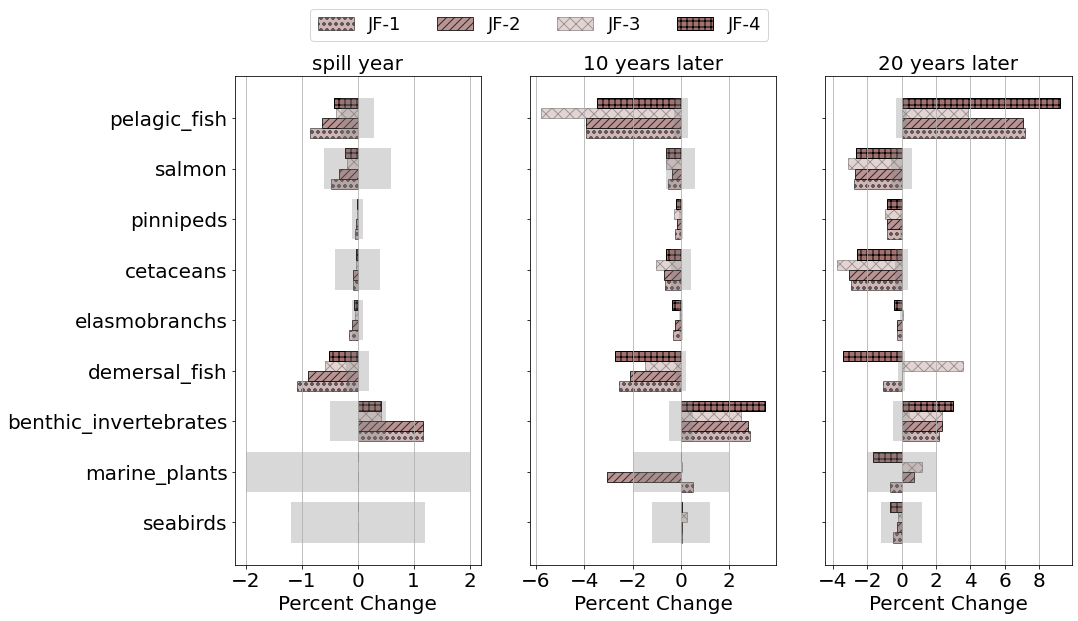

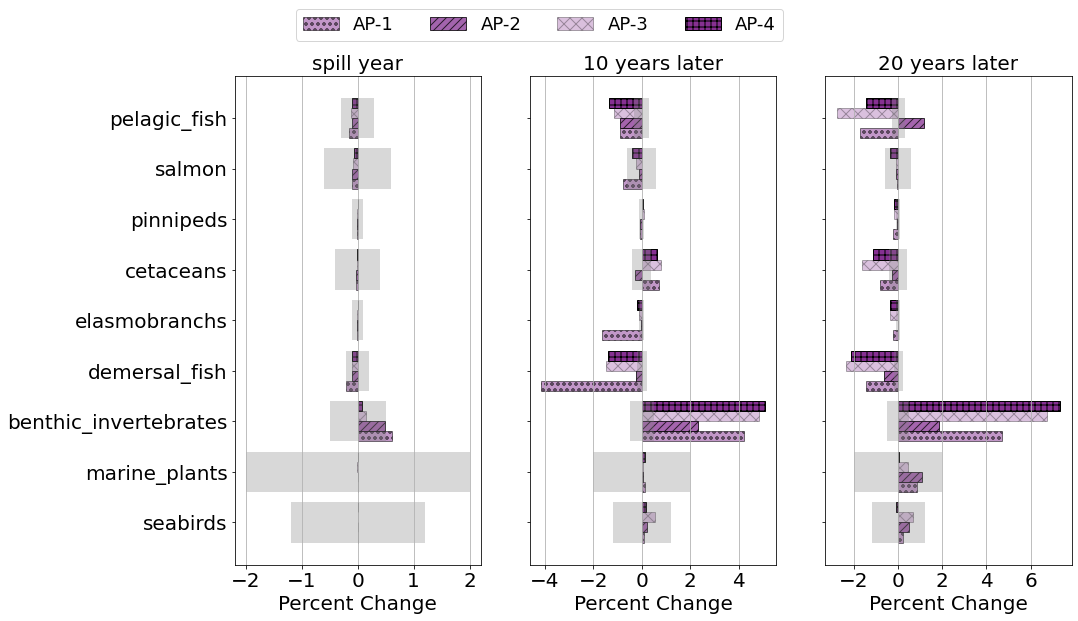

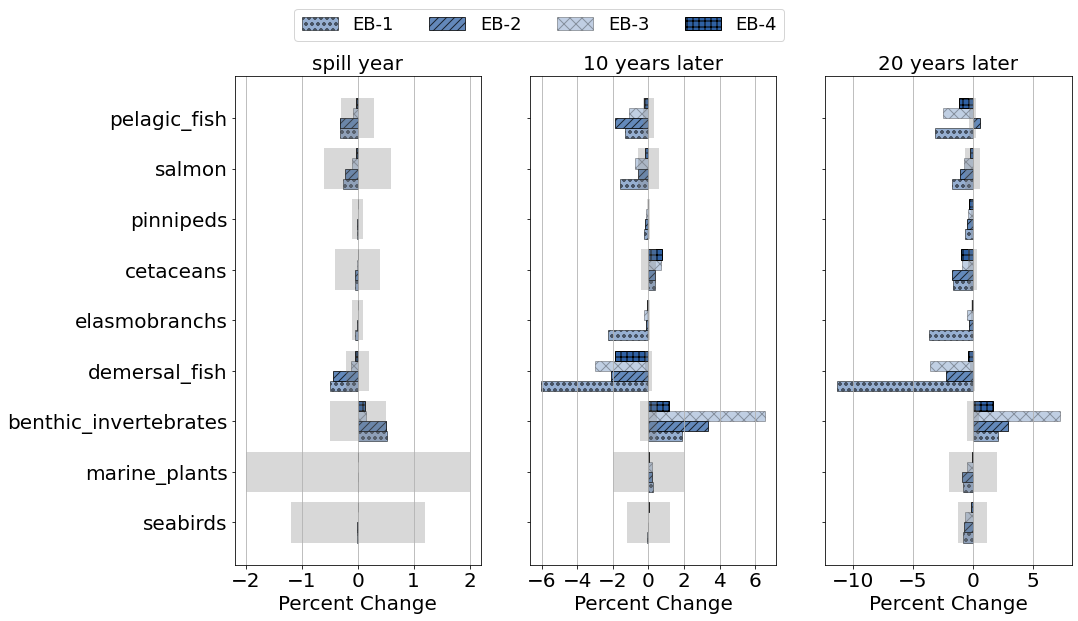

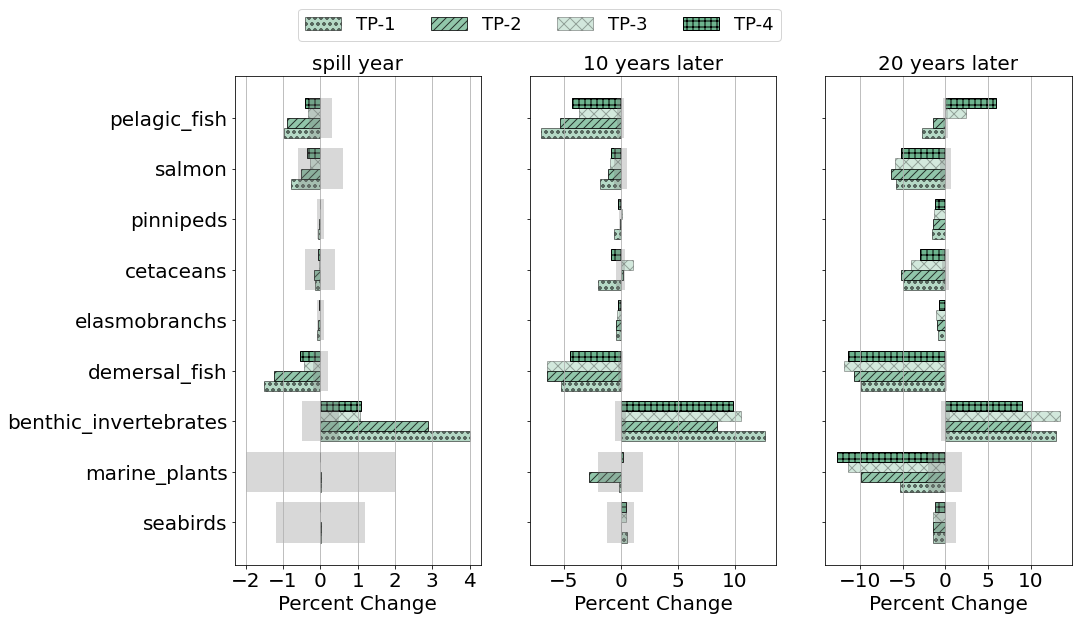

In [36]:
x_lim = None #[-12, 15]
for code_name in code_names:
    n_rows = len(bio_groups)
    if n_rows < 7:
        n_rows = 7
    elif n_rows >10:
        n_rows = 15
    else:
            n_rows = n_rows
    n_cols = len(time_labels)
    fig, axes = plt.subplots(1, n_cols, figsize=(5 * n_cols, n_rows), sharey=True)

    if n_cols == 1:
        axes = [axes]  

    if code_name == 'AP':
        hex_colour = '#863092'
    elif code_name == 'TP':
        hex_colour = '#6DB48E'
    elif code_name == 'EB':
        hex_colour = '#2F61A4'
    elif code_name == 'JF':
        hex_colour = '#A27170'
    
    these_scenarios = [code_name+'-1',code_name+'-2',code_name+'-3',code_name+'-4']

    bar_width = 0.8 / len(these_scenarios)  
    y_pos = np.arange(len(bio_groups))

    for i, time in enumerate(time_labels):
        ax = axes[i]
        for j, scenario in enumerate(these_scenarios):
            df_plot = df[(df['time_label'] == time) & (df['scenario'] == scenario)]
            df_plot = df_plot.set_index('bio_group').reindex(bio_groups)  
            offset = (j - len(these_scenarios)/2) * bar_width + bar_width/2

            ax.barh(y_pos + offset, df_plot['percent_change'], height=bar_width, label=scenario, facecolor=hex_colour, alpha=alphas[j], edgecolor='black', hatch=hatches[j])
        ax.barh(bio_groups, df_plot['sensitivity'], label=scenario, color='grey', alpha=0.3)
        ax.barh(bio_groups, df_plot['sensitivity_negative'], label=scenario, color='grey', alpha=0.3)
        ax.xaxis.grid(True)
        xlabels = ax.get_xticklabels()
        plt.setp(xlabels, fontsize=20)
    
        ax.set_title(time, fontsize=20)
        ax.set_yticks(y_pos)
        ax.set_yticklabels(bio_groups, fontsize=20) 
        ax.set_xlim(x_lim)
        ax.set_xlabel("Percent Change", fontsize=20)

    fig.legend(these_scenarios, loc='upper center', ncol=len(these_scenarios), fontsize=18) 
    plt.show()

For presentations

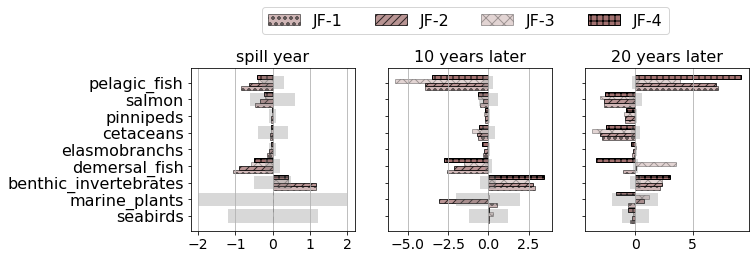

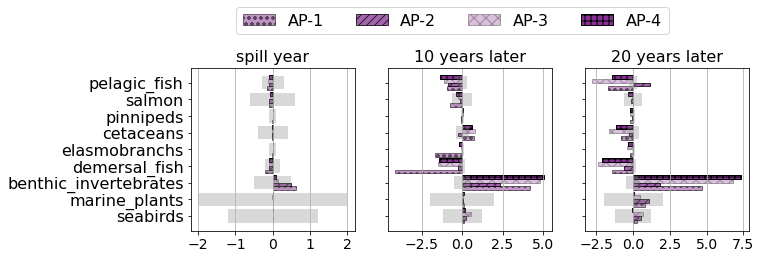

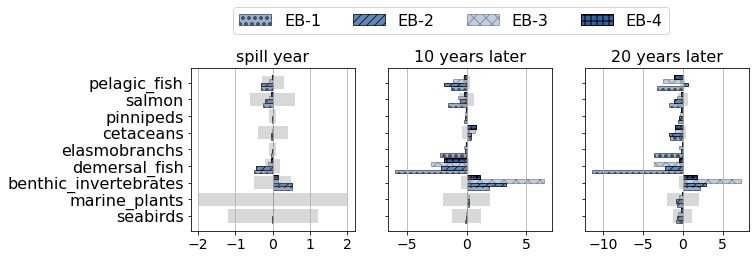

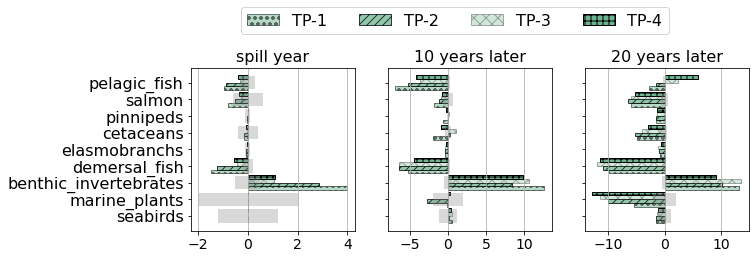

In [37]:
x_lim = None #[-12,15]
for code_name in code_names:
    n_rows = len(bio_groups)
    if n_rows < 7:
        n_rows = 7
    elif n_rows >10:
        n_rows = 15
    else:
            n_rows = n_rows
    n_cols = len(time_labels)
    fig, axes = plt.subplots(1, n_cols, figsize=(10, 3), sharey=True)

    if n_cols == 1:
        axes = [axes]  

    if code_name == 'AP':
        hex_colour = '#863092'
    elif code_name == 'TP':
        hex_colour = '#6DB48E'
    elif code_name == 'EB':
        hex_colour = '#2F61A4'
    elif code_name == 'JF':
        hex_colour = '#A27170'
    
    these_scenarios = [code_name+'-1',code_name+'-2',code_name+'-3',code_name+'-4']

    bar_width = 0.9 / len(these_scenarios)  
    y_pos = np.arange(len(bio_groups))

    for i, time in enumerate(time_labels):
        ax = axes[i]
        for j, scenario in enumerate(these_scenarios):
            df_plot = df[(df['time_label'] == time) & (df['scenario'] == scenario)]
            df_plot = df_plot.set_index('bio_group').reindex(bio_groups)  
            offset = (j - len(these_scenarios)/2) * bar_width + bar_width/2

            ax.barh(y_pos + offset, df_plot['percent_change'], height=bar_width, label=scenario, facecolor=hex_colour, alpha=alphas[j], edgecolor='black', hatch=hatches[j])
        ax.barh(bio_groups, df_plot['sensitivity'], label=scenario, color='grey', alpha=0.3)
        ax.barh(bio_groups, df_plot['sensitivity_negative'], label=scenario, color='grey', alpha=0.3)
        ax.xaxis.grid(True)
        xlabels = ax.get_xticklabels()
        plt.setp(xlabels, fontsize=14)
    
        ax.set_title(time, fontsize=16)
        ax.set_yticks(y_pos)
        ax.set_yticklabels(bio_groups, fontsize=16) 
        ax.set_xlim(x_lim)
        #ax.set_xlabel("Percent Change", fontsize=16)

    fig.legend(these_scenarios, ncol=len(these_scenarios), bbox_to_anchor=(0.8, 1.2), fontsize=16) 
    plt.show()